In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error

In [23]:
def balanced_batch_generator_reg(data, labels, M, K):
    """
    Generates K batches of data and associated labels, each of size M, ensuring 
    that each data point appears in at least one batch.

    Parameters:
    - data (numpy.array): The dataset.
    - labels (numpy.array): Corresponding labels for the dataset.
    - M (int): Batch size.
    - K (int): Number of batches.

    Yields:
    - tuple: Batches of data and corresponding labels.
    """

    # Get total number of data samples
    num_samples = len(data)

    # Initialize a set to track unique batches
    selected_batches = set()

    # Sample until we obtain K unique batches
    while len(selected_batches) < K:
        # Generate indices and shuffle them
        all_indices = np.arange(num_samples)
        np.random.shuffle(all_indices)
        
        # Iterate over data and form batches of size M
        for i in range(0, num_samples, M):
            if i + M >= num_samples: break # (removes last batch if needed)
        
            batch_indices = tuple(sorted(all_indices[i:i+M]))
            if batch_indices not in selected_batches:
                selected_batches.add(batch_indices)
            
            if len(selected_batches) >= K: break

    # Transform the set to a list
    selected_batches = list(selected_batches)

    # Yield data batches with their labels
    for indices in selected_batches:
        yield data[np.array(indices)], labels[np.array(indices)]
        
# Define the neural network for regression
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.output(x)
        return x

## California Housing Dataset

In [15]:
torch.manual_seed(42)

# Load the California Housing dataset
housing = fetch_california_housing()
X_data, y_data = housing.data, housing.target

# Preprocess the data: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).view(-1, 1).to(device)  # Reshape y_train to have 2 dimensions
y_test = torch.FloatTensor(y_test).view(-1, 1).to(device)   # Reshape y_test to have 2 dimensions

In [17]:
# Training and evaluation settings
iterations = 5
num_epochs = 50
batch_size = 100
num_batches = 1000

mae_train_array = np.zeros((num_epochs, iterations))
mae_test_array = np.zeros((num_epochs, iterations))
rlp_train_array = np.zeros((num_epochs, iterations))
rlp_test_array = np.zeros((num_epochs, iterations))

criterion_mae = nn.L1Loss()  # MAE loss
criterion_rlp = nn.MSELoss() # MSE Loss

for i in range(iterations):
    model_mae = RegressionModel(X_train.shape[1]).to(device)
    model_rlp = RegressionModel(X_train.shape[1]).to(device)
    optimizer_mae = optim.Adam(model_mae.parameters(), lr=5e-4)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=5e-4)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train, batch_size, num_batches))

    for epoch in range(num_epochs):
        epoch_loss_mae = 0; epoch_loss_rlp = 0;
        # Training loop for MAE
        model_mae.train()
        for batch_X, batch_y in train_dataloader:
            optimizer_mae.zero_grad()
            outputs = model_mae(batch_X)
            loss_mae = criterion_mae(outputs, batch_y)
            
            loss_mae.backward()
            optimizer_mae.step()
            epoch_loss_mae += loss_mae.item()
            
        # Training loop for RLP
        model_rlp.train()
        for batch_X, batch_y in unique_batches:
            optimizer_rlp.zero_grad()
            outputs = model_rlp(batch_X)
            c = torch.linalg.lstsq(batch_X, batch_y).solution
            c_pred = torch.linalg.lstsq(batch_X, outputs).solution
            loss_rlp = criterion_rlp(batch_X @ c_pred, batch_X @ c) # RLP Loss
            
            loss_rlp.backward()
            optimizer_rlp.step()
            epoch_loss_rlp += loss_rlp.item()

        # Evaluation on training set
        model_mae.eval(); model_rlp.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_mae = model_mae(X_test)
            predictions_rlp = model_rlp(X_test)
            
            mae_test = criterion_mae(predictions_mae, y_test)
            rlp_test = criterion_mae(predictions_rlp, y_test)
            
            mae_train_array[epoch, i] = epoch_loss_mae / len(train_dataloader)
            rlp_train_array[epoch, i] = epoch_loss_rlp / num_batches
            mae_test_array[epoch, i] = mae_test
            rlp_test_array[epoch, i] = rlp_test

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, Test MAE: {mae_test:.4f}, Test RLP: {rlp_test:.4f}')

Iteration: 1, Epoch: 1, Test MAE: 1.6685, Test RLP: 0.8809
Iteration: 1, Epoch: 2, Test MAE: 1.4149, Test RLP: 0.7279
Iteration: 1, Epoch: 3, Test MAE: 1.2379, Test RLP: 0.6469
Iteration: 1, Epoch: 4, Test MAE: 0.9629, Test RLP: 0.6227
Iteration: 1, Epoch: 5, Test MAE: 0.8544, Test RLP: 0.6352
Iteration: 1, Epoch: 6, Test MAE: 1.0709, Test RLP: 0.6187
Iteration: 1, Epoch: 7, Test MAE: 0.7492, Test RLP: 0.6108
Iteration: 1, Epoch: 8, Test MAE: 0.6519, Test RLP: 0.6085
Iteration: 1, Epoch: 9, Test MAE: 0.7566, Test RLP: 0.6071
Iteration: 1, Epoch: 10, Test MAE: 0.6999, Test RLP: 0.6043
Iteration: 1, Epoch: 11, Test MAE: 0.6231, Test RLP: 0.5998
Iteration: 1, Epoch: 12, Test MAE: 0.5972, Test RLP: 0.5970
Iteration: 1, Epoch: 13, Test MAE: 0.6273, Test RLP: 0.6005
Iteration: 1, Epoch: 14, Test MAE: 0.6486, Test RLP: 0.6042
Iteration: 1, Epoch: 15, Test MAE: 0.6422, Test RLP: 0.6005
Iteration: 1, Epoch: 16, Test MAE: 0.6174, Test RLP: 0.6002
Iteration: 1, Epoch: 17, Test MAE: 0.5851, Test R

Iteration: 3, Epoch: 38, Test MAE: 0.5815, Test RLP: 0.5981
Iteration: 3, Epoch: 39, Test MAE: 0.5561, Test RLP: 0.6517
Iteration: 3, Epoch: 40, Test MAE: 0.5649, Test RLP: 0.6583
Iteration: 3, Epoch: 41, Test MAE: 0.5683, Test RLP: 0.6757
Iteration: 3, Epoch: 42, Test MAE: 0.5570, Test RLP: 0.6605
Iteration: 3, Epoch: 43, Test MAE: 0.7511, Test RLP: 0.6574
Iteration: 3, Epoch: 44, Test MAE: 0.5554, Test RLP: 0.6579
Iteration: 3, Epoch: 45, Test MAE: 0.6672, Test RLP: 0.6578
Iteration: 3, Epoch: 46, Test MAE: 0.5672, Test RLP: 0.6596
Iteration: 3, Epoch: 47, Test MAE: 0.5590, Test RLP: 0.5852
Iteration: 3, Epoch: 48, Test MAE: 0.5493, Test RLP: 0.6571
Iteration: 3, Epoch: 49, Test MAE: 0.5593, Test RLP: 0.6500
Iteration: 3, Epoch: 50, Test MAE: 0.6726, Test RLP: 0.6614
Iteration: 4, Epoch: 1, Test MAE: 1.4584, Test RLP: 0.7585
Iteration: 4, Epoch: 2, Test MAE: 1.2316, Test RLP: 0.6547
Iteration: 4, Epoch: 3, Test MAE: 0.9396, Test RLP: 0.6232
Iteration: 4, Epoch: 4, Test MAE: 0.8088, T

Mean MAE:       0.6655, STDEV MAE:      0.1016
Mean RLP (100): 0.5773, STDEV RLP:      0.0492


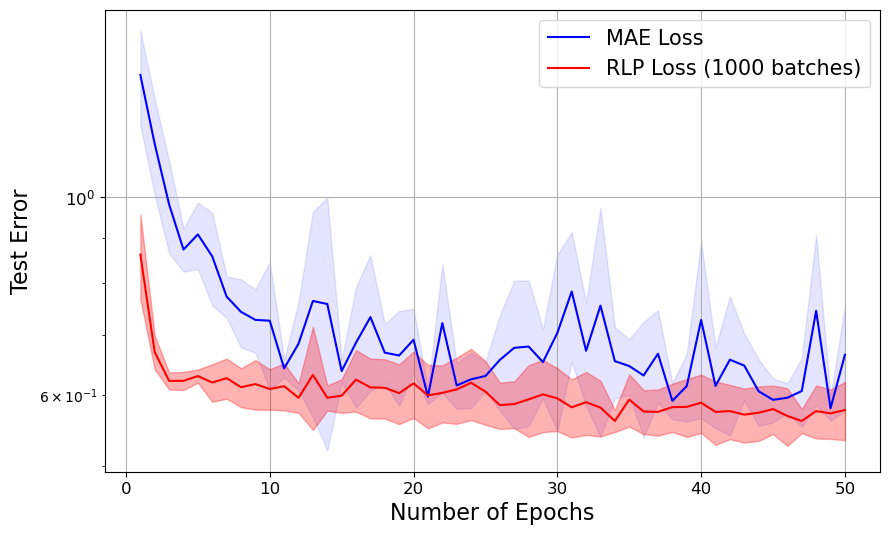

In [19]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    stdev = np.std(data, axis=0)
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci, stdev

X = mae_test_array.T; Z = rlp_test_array.T
mean_X, ci_X, stdev_X = compute_mean_and_CI(X)
mean_Z, ci_Z, stdev_Z = compute_mean_and_CI(Z)

print(f'Mean MAE:       {mean_X[len(mean_X)-1].round(4)}, STDEV MAE:      {stdev_X[len(stdev_X)-1].round(4)}')
print(f'Mean RLP (100): {mean_Z[len(mean_Z)-1].round(4)}, STDEV RLP:      {stdev_Z[len(stdev_Z)-1].round(4)}')

# Step 3: Plot the results
epochs_all = list(range(1, X.shape[1] + 1))
plt.figure(figsize=(10, 6))

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_X, 'b-', label="MAE Loss", zorder=20)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, 'r-', label="RLP Loss (1000 batches)", zorder=30)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=16)
plt.ylabel("Test Error", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.grid(True)
plt.show()

## Wine Quality Dataset

In [25]:
torch.manual_seed(42)

# Load the California Housing dataset
wine = fetch_openml(name='wine_quality', version=1, parser='auto')
X_data, y_data = wine.data.to_numpy(), np.expand_dims(wine.target.to_numpy(),1)

# Preprocess the data: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).view(-1, 1).to(device)  # Reshape y_train to have 2 dimensions
y_test = torch.FloatTensor(y_test).view(-1, 1).to(device)   # Reshape y_test to have 2 dimensions

In [26]:
# Training and evaluation settings
iterations = 5
num_epochs = 50
batch_size = 100
num_batches = 1000

mae_train_array = np.zeros((num_epochs, iterations))
mae_test_array = np.zeros((num_epochs, iterations))
rlp_train_array = np.zeros((num_epochs, iterations))
rlp_test_array = np.zeros((num_epochs, iterations))

criterion_mae = nn.L1Loss()  # MAE loss
criterion_rlp = nn.MSELoss() # MSE Loss

for i in range(iterations):
    model_mae = RegressionModel(X_train.shape[1]).to(device)
    model_rlp = RegressionModel(X_train.shape[1]).to(device)
    optimizer_mae = optim.Adam(model_mae.parameters(), lr=5e-4)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=5e-4)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train, batch_size, num_batches))

    for epoch in range(num_epochs):
        epoch_loss_mae = 0; epoch_loss_rlp = 0;
        # Training loop for MAE
        model_mae.train()
        for batch_X, batch_y in train_dataloader:
            optimizer_mae.zero_grad()
            outputs = model_mae(batch_X)
            loss_mae = criterion_mae(outputs, batch_y)
            
            loss_mae.backward()
            optimizer_mae.step()
            epoch_loss_mae += loss_mae.item()
            
        # Training loop for RLP
        model_rlp.train()
        for batch_X, batch_y in unique_batches:
            optimizer_rlp.zero_grad()
            outputs = model_rlp(batch_X)
            c = torch.linalg.lstsq(batch_X, batch_y).solution
            c_pred = torch.linalg.lstsq(batch_X, outputs).solution
            loss_rlp = criterion_rlp(batch_X @ c_pred, batch_X @ c) # RLP Loss
            
            loss_rlp.backward()
            optimizer_rlp.step()
            epoch_loss_rlp += loss_rlp.item()

        # Evaluation on training set
        model_mae.eval(); model_rlp.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_mae = model_mae(X_test)
            predictions_rlp = model_rlp(X_test)
            
            mae_test = criterion_mae(predictions_mae, y_test)
            rlp_test = criterion_mae(predictions_rlp, y_test)
            
            mae_train_array[epoch, i] = epoch_loss_mae / len(train_dataloader)
            rlp_train_array[epoch, i] = epoch_loss_rlp / num_batches
            mae_test_array[epoch, i] = mae_test
            rlp_test_array[epoch, i] = rlp_test

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, Test MAE: {mae_test:.4f}, Test RLP: {rlp_test:.4f}')

Iteration: 1, Epoch: 1, Test MAE: 2.2641, Test RLP: 0.6106
Iteration: 1, Epoch: 2, Test MAE: 1.9607, Test RLP: 0.6003
Iteration: 1, Epoch: 3, Test MAE: 1.6509, Test RLP: 0.5938
Iteration: 1, Epoch: 4, Test MAE: 1.2283, Test RLP: 0.5882
Iteration: 1, Epoch: 5, Test MAE: 0.9312, Test RLP: 0.5852
Iteration: 1, Epoch: 6, Test MAE: 0.7632, Test RLP: 0.5821
Iteration: 1, Epoch: 7, Test MAE: 0.7227, Test RLP: 0.5798
Iteration: 1, Epoch: 8, Test MAE: 0.7144, Test RLP: 0.5772
Iteration: 1, Epoch: 9, Test MAE: 0.7033, Test RLP: 0.5759
Iteration: 1, Epoch: 10, Test MAE: 0.6958, Test RLP: 0.5752
Iteration: 1, Epoch: 11, Test MAE: 0.6892, Test RLP: 0.5748
Iteration: 1, Epoch: 12, Test MAE: 0.7049, Test RLP: 0.5744
Iteration: 1, Epoch: 13, Test MAE: 0.6893, Test RLP: 0.5741
Iteration: 1, Epoch: 14, Test MAE: 0.6738, Test RLP: 0.5740
Iteration: 1, Epoch: 15, Test MAE: 0.6690, Test RLP: 0.5737
Iteration: 1, Epoch: 16, Test MAE: 0.6711, Test RLP: 0.5734
Iteration: 1, Epoch: 17, Test MAE: 0.6643, Test R

Iteration: 3, Epoch: 38, Test MAE: 0.6154, Test RLP: 0.5722
Iteration: 3, Epoch: 39, Test MAE: 0.6077, Test RLP: 0.5722
Iteration: 3, Epoch: 40, Test MAE: 0.5979, Test RLP: 0.5723
Iteration: 3, Epoch: 41, Test MAE: 0.6045, Test RLP: 0.5722
Iteration: 3, Epoch: 42, Test MAE: 0.5941, Test RLP: 0.5723
Iteration: 3, Epoch: 43, Test MAE: 0.6061, Test RLP: 0.5726
Iteration: 3, Epoch: 44, Test MAE: 0.5993, Test RLP: 0.5726
Iteration: 3, Epoch: 45, Test MAE: 0.5926, Test RLP: 0.5728
Iteration: 3, Epoch: 46, Test MAE: 0.5938, Test RLP: 0.5727
Iteration: 3, Epoch: 47, Test MAE: 0.5917, Test RLP: 0.5729
Iteration: 3, Epoch: 48, Test MAE: 0.5958, Test RLP: 0.5730
Iteration: 3, Epoch: 49, Test MAE: 0.6039, Test RLP: 0.5729
Iteration: 3, Epoch: 50, Test MAE: 0.5919, Test RLP: 0.5730
Iteration: 4, Epoch: 1, Test MAE: 2.5904, Test RLP: 0.6189
Iteration: 4, Epoch: 2, Test MAE: 2.3445, Test RLP: 0.5998
Iteration: 4, Epoch: 3, Test MAE: 1.9668, Test RLP: 0.5889
Iteration: 4, Epoch: 4, Test MAE: 1.5406, T

Mean MAE:       0.5949, STDEV MAE:      0.01
Mean RLP (100): 0.5706, STDEV RLP:      0.0012


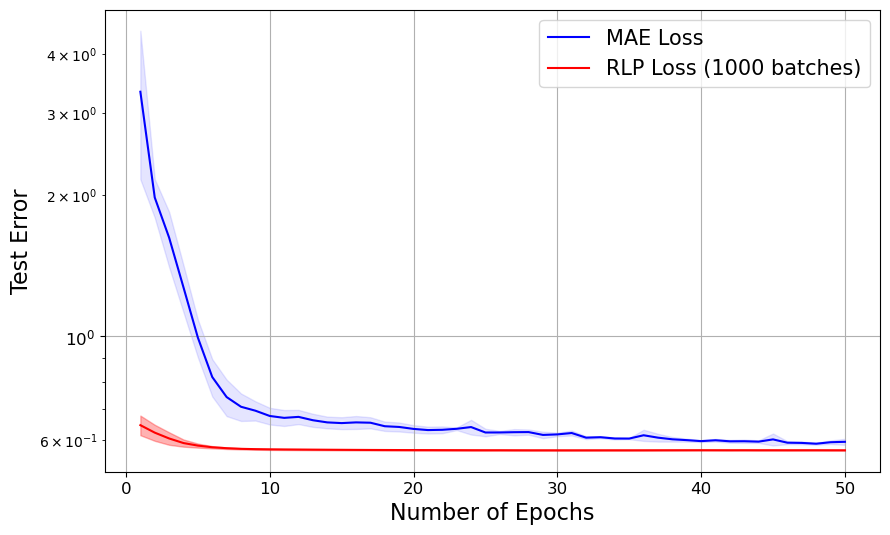

In [27]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    stdev = np.std(data, axis=0)
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci, stdev

X = mae_test_array.T; Z = rlp_test_array.T
mean_X, ci_X, stdev_X = compute_mean_and_CI(X)
mean_Z, ci_Z, stdev_Z = compute_mean_and_CI(Z)

print(f'Mean MAE:       {mean_X[len(mean_X)-1].round(4)}, STDEV MAE:      {stdev_X[len(stdev_X)-1].round(4)}')
print(f'Mean RLP (100): {mean_Z[len(mean_Z)-1].round(4)}, STDEV RLP:      {stdev_Z[len(stdev_Z)-1].round(4)}')

# Step 3: Plot the results
epochs_all = list(range(1, X.shape[1] + 1))
plt.figure(figsize=(10, 6))

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_X, 'b-', label="MAE Loss", zorder=20)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, 'r-', label="RLP Loss (1000 batches)", zorder=30)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=16)
plt.ylabel("Test Error", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.grid(True)
plt.show()

## Nonlinear Dataset

In [28]:
torch.manual_seed(42)

# MULTIDIMENSIONAL DATASET
rng = np.random.RandomState(1)
X = rng.rand(6000, 7) # Same dataset will now be used across different trials
y = np.expand_dims((X[:,0] + X[:,1]**2 + X[:,2]**3 + X[:,3]**4 + X[:,4]**5 + np.exp(X[:,5]) + np.sin(X[:,6])), 1)
X_data, y_data = X, y

# Preprocess the data: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).view(-1, 1).to(device)  # Reshape y_train to have 2 dimensions
y_test = torch.FloatTensor(y_test).view(-1, 1).to(device)   # Reshape y_test to have 2 dimensions

In [29]:
# Training and evaluation settings
iterations = 5
num_epochs = 50
batch_size = 100
num_batches = 1000

mae_train_array = np.zeros((num_epochs, iterations))
mae_test_array = np.zeros((num_epochs, iterations))
rlp_train_array = np.zeros((num_epochs, iterations))
rlp_test_array = np.zeros((num_epochs, iterations))

criterion_mae = nn.L1Loss()  # MAE loss
criterion_rlp = nn.MSELoss() # MSE Loss

for i in range(iterations):
    model_mae = RegressionModel(X_train.shape[1]).to(device)
    model_rlp = RegressionModel(X_train.shape[1]).to(device)
    optimizer_mae = optim.Adam(model_mae.parameters(), lr=5e-4)
    optimizer_rlp = optim.Adam(model_rlp.parameters(), lr=5e-4)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    unique_batches = list(balanced_batch_generator_reg(X_train, y_train, batch_size, num_batches))

    for epoch in range(num_epochs):
        epoch_loss_mae = 0; epoch_loss_rlp = 0;
        # Training loop for MAE
        model_mae.train()
        for batch_X, batch_y in train_dataloader:
            optimizer_mae.zero_grad()
            outputs = model_mae(batch_X)
            loss_mae = criterion_mae(outputs, batch_y)
            
            loss_mae.backward()
            optimizer_mae.step()
            epoch_loss_mae += loss_mae.item()
            
        # Training loop for RLP
        model_rlp.train()
        for batch_X, batch_y in unique_batches:
            optimizer_rlp.zero_grad()
            outputs = model_rlp(batch_X)
            c = torch.linalg.lstsq(batch_X, batch_y).solution
            c_pred = torch.linalg.lstsq(batch_X, outputs).solution
            loss_rlp = criterion_rlp(batch_X @ c_pred, batch_X @ c) # RLP Loss
            
            loss_rlp.backward()
            optimizer_rlp.step()
            epoch_loss_rlp += loss_rlp.item()

        # Evaluation on training set
        model_mae.eval(); model_rlp.eval();
        with torch.no_grad():
            # Evaluation on test set
            predictions_mae = model_mae(X_test)
            predictions_rlp = model_rlp(X_test)
            
            mae_test = criterion_mae(predictions_mae, y_test)
            rlp_test = criterion_mae(predictions_rlp, y_test)
            
            mae_train_array[epoch, i] = epoch_loss_mae / len(train_dataloader)
            rlp_train_array[epoch, i] = epoch_loss_rlp / num_batches
            mae_test_array[epoch, i] = mae_test
            rlp_test_array[epoch, i] = rlp_test

        print(f'Iteration: {i+1}, Epoch: {epoch+1}, Test MAE: {mae_test:.4f}, Test RLP: {rlp_test:.4f}')

Iteration: 1, Epoch: 1, Test MAE: 3.3885, Test RLP: 0.2774
Iteration: 1, Epoch: 2, Test MAE: 3.2341, Test RLP: 0.2357
Iteration: 1, Epoch: 3, Test MAE: 3.0393, Test RLP: 0.2300
Iteration: 1, Epoch: 4, Test MAE: 2.7694, Test RLP: 0.2253
Iteration: 1, Epoch: 5, Test MAE: 2.4007, Test RLP: 0.2199
Iteration: 1, Epoch: 6, Test MAE: 1.9356, Test RLP: 0.2146
Iteration: 1, Epoch: 7, Test MAE: 1.3867, Test RLP: 0.2095
Iteration: 1, Epoch: 8, Test MAE: 0.7822, Test RLP: 0.2048
Iteration: 1, Epoch: 9, Test MAE: 0.4134, Test RLP: 0.2007
Iteration: 1, Epoch: 10, Test MAE: 0.3847, Test RLP: 0.1969
Iteration: 1, Epoch: 11, Test MAE: 0.3752, Test RLP: 0.1935
Iteration: 1, Epoch: 12, Test MAE: 0.3649, Test RLP: 0.1902
Iteration: 1, Epoch: 13, Test MAE: 0.3554, Test RLP: 0.1874
Iteration: 1, Epoch: 14, Test MAE: 0.3458, Test RLP: 0.1848
Iteration: 1, Epoch: 15, Test MAE: 0.3360, Test RLP: 0.1823
Iteration: 1, Epoch: 16, Test MAE: 0.3265, Test RLP: 0.1798
Iteration: 1, Epoch: 17, Test MAE: 0.3174, Test R

Iteration: 3, Epoch: 38, Test MAE: 0.1920, Test RLP: 0.1465
Iteration: 3, Epoch: 39, Test MAE: 0.1915, Test RLP: 0.1437
Iteration: 3, Epoch: 40, Test MAE: 0.1911, Test RLP: 0.1407
Iteration: 3, Epoch: 41, Test MAE: 0.1912, Test RLP: 0.1376
Iteration: 3, Epoch: 42, Test MAE: 0.1910, Test RLP: 0.1346
Iteration: 3, Epoch: 43, Test MAE: 0.1909, Test RLP: 0.1316
Iteration: 3, Epoch: 44, Test MAE: 0.1891, Test RLP: 0.1286
Iteration: 3, Epoch: 45, Test MAE: 0.1887, Test RLP: 0.1258
Iteration: 3, Epoch: 46, Test MAE: 0.1882, Test RLP: 0.1231
Iteration: 3, Epoch: 47, Test MAE: 0.1882, Test RLP: 0.1208
Iteration: 3, Epoch: 48, Test MAE: 0.1874, Test RLP: 0.1186
Iteration: 3, Epoch: 49, Test MAE: 0.1858, Test RLP: 0.1166
Iteration: 3, Epoch: 50, Test MAE: 0.1853, Test RLP: 0.1147
Iteration: 4, Epoch: 1, Test MAE: 3.4987, Test RLP: 0.2871
Iteration: 4, Epoch: 2, Test MAE: 3.2546, Test RLP: 0.2509
Iteration: 4, Epoch: 3, Test MAE: 2.9351, Test RLP: 0.2460
Iteration: 4, Epoch: 4, Test MAE: 2.5184, T

Mean MAE:       0.1912, STDEV MAE:      0.004
Mean RLP (100): 0.0993, STDEV RLP:      0.0132


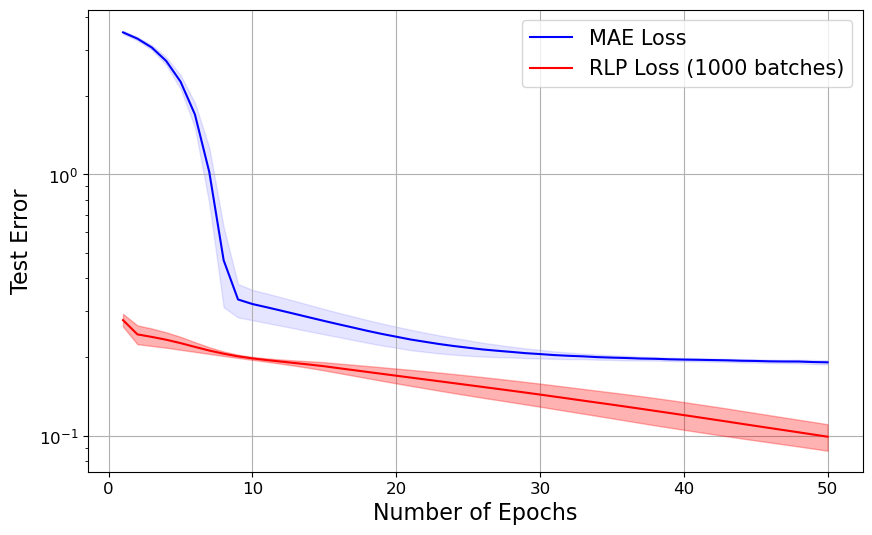

In [30]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    stdev = np.std(data, axis=0)
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci, stdev

X = mae_test_array.T; Z = rlp_test_array.T
mean_X, ci_X, stdev_X = compute_mean_and_CI(X)
mean_Z, ci_Z, stdev_Z = compute_mean_and_CI(Z)

print(f'Mean MAE:       {mean_X[len(mean_X)-1].round(4)}, STDEV MAE:      {stdev_X[len(stdev_X)-1].round(4)}')
print(f'Mean RLP (100): {mean_Z[len(mean_Z)-1].round(4)}, STDEV RLP:      {stdev_Z[len(stdev_Z)-1].round(4)}')

# Step 3: Plot the results
epochs_all = list(range(1, X.shape[1] + 1))
plt.figure(figsize=(10, 6))

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_X, 'b-', label="MAE Loss", zorder=20)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, 'r-', label="RLP Loss (1000 batches)", zorder=30)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=16)
plt.ylabel("Test Error", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 15})
plt.grid(True)
plt.show()